In [1]:
from collections import defaultdict
from rdkit import Chem

START_PLACEHOLDER_MAP_FROM = 1000 # don't change

In [36]:
def dict_of_lists_update(target_dict, source_dict):
    for key, value in source_dict.items():
        target_dict[key].extend(value)

    return target_dict


def delete_substructs(complete_mol, matched_atom_maps):

    filtered_smiles = []
    all_mols_smiles = Chem.MolToSmiles(complete_mol)
    detached_mols_smiles = all_mols_smiles.split(".")
    substruct_smiles = None

    for mol_smiles in detached_mols_smiles:
        mol = Chem.MolFromSmiles(mol_smiles)

        atom_maps = [atom.GetAtomMapNum() for atom in mol.GetAtoms()]
        if set(atom_maps) == matched_atom_maps:
            substruct_smiles = mol_smiles
        else:
            filtered_smiles.append(mol_smiles)

    filtered_smiles = '.'.join(filtered_smiles)
    filtered_mol = Chem.RWMol(Chem.MolFromSmiles(filtered_smiles))
    return filtered_mol, substruct_smiles


In [37]:
def simplify_substructs(mol, all_maccs_smarts, ):

    curr_placeholder_map_num = START_PLACEHOLDER_MAP_FROM
    all_bonds_for_reconstruction = defaultdict(list)
    placeholder_to_substruct_dict = dict()

    mol = Chem.RWMol(mol) # make editable

    for maccs_smart in all_maccs_smarts:

        pattern = Chem.MolFromSmarts(maccs_smart)
        match_tuple = mol.GetSubstructMatch(pattern)

        while match_tuple:

            bonds_to_remove = []
            bonds_to_add_back = dict()

            matched_atom_maps = set()
            matched_atom_ids = set(match_tuple)
            bonds_for_reconstruction = defaultdict(list)

            for subs_atom_id in match_tuple:
                subs_atom = mol.GetAtomWithIdx(subs_atom_id)
                matched_atom_maps.add(subs_atom.GetAtomMapNum())

                for nbr_atom in subs_atom.GetNeighbors():

                    if nbr_atom.GetIdx() in matched_atom_ids:
                        continue

                    bond_type = mol.GetBondBetweenAtoms(nbr_atom.GetIdx(), subs_atom_id).GetBondType()
                    bonds_to_remove.append((nbr_atom, subs_atom, bond_type))
                    bonds_to_add_back[nbr_atom.GetAtomMapNum()] = bond_type

                    if nbr_atom.GetAtomMapNum() < START_PLACEHOLDER_MAP_FROM:
                        bonds_for_reconstruction[nbr_atom.GetAtomMapNum()].append((subs_atom.GetAtomMapNum(), bond_type))
                        bonds_for_reconstruction[subs_atom.GetAtomMapNum()].append((nbr_atom.GetAtomMapNum(), bond_type))

            # disconnect substructure from neighbors
            for (nbr_atom, subs_atom, bond_type)  in bonds_to_remove:

                nbr_atom_explicit_Hs = nbr_atom.GetNumExplicitHs()
                subs_atom_explicit_Hs = subs_atom.GetNumExplicitHs()
                mol.RemoveBond(nbr_atom.GetIdx(), subs_atom.GetIdx())

                nbr_atom.SetNumExplicitHs(nbr_atom_explicit_Hs + int(bond_type))
                subs_atom.SetNumExplicitHs(subs_atom_explicit_Hs + int(bond_type))

            # deleting substructure match
            mol, substruct_smiles = delete_substructs(mol, matched_atom_maps)

            # for reconstruction
            all_bonds_for_reconstruction = dict_of_lists_update(all_bonds_for_reconstruction, bonds_for_reconstruction)
            placeholder_to_substruct_dict[curr_placeholder_map_num] = substruct_smiles

            # replacing substructure with placeholder
            placeholder_atom = Chem.Atom('*')
            placeholder_atom.SetAtomMapNum(curr_placeholder_map_num)
            curr_placeholder_map_num += 1
            placeholder_atom_id = mol.AddAtom(placeholder_atom)

            # after DeleteSubstructs, atom indices will be changed but atom maps will be the same
            # hence, we have to make use of atom map numbers after delete (as used in bonds_to_add_back)
            for atom in mol.GetAtoms():
                if atom.GetAtomMapNum() in bonds_to_add_back:
                    explicit_Hs = atom.GetNumExplicitHs()
                    mol.AddBond(placeholder_atom_id, atom.GetIdx(), bonds_to_add_back[atom.GetAtomMapNum()])
                    atom.SetNumExplicitHs(explicit_Hs - bonds_to_add_back[atom.GetAtomMapNum()])

            match_tuple = mol.GetSubstructMatch(pattern)
            # Possible improvement: use GetSubstructureMatches() and do one
            # deletion for each match of the current maccs_smart.

    return mol, placeholder_to_substruct_dict, all_bonds_for_reconstruction


In [38]:
import re

def expand_substructs(simplified_mol, placeholder_to_substruct_dict, all_bonds_for_reconstruction):

    # remove connections with placeholder atoms
    for atom in simplified_mol.GetAtoms():
        if atom.GetSymbol() == '*':
            for nbr_atom in atom.GetNeighbors():
                bond_type = simplified_mol.GetBondBetweenAtoms(atom.GetIdx(), nbr_atom.GetIdx()).GetBondType()
                explicit_Hs = nbr_atom.GetNumExplicitHs()
                simplified_mol.RemoveBond(nbr_atom.GetIdx(), atom.GetIdx())
                if nbr_atom.GetSymbol() != '*':
                    nbr_atom.SetNumExplicitHs(explicit_Hs + int(bond_type))

    all_mols_smiles = Chem.MolToSmiles(simplified_mol)
    detached_smiles = all_mols_smiles.split('.')
    regex_pattern = re.compile("(\[\*:)[1-9][0-9][0-9][0-9]\]")
    expanded_smiles = []

    # remove connections with placeholder atoms
    for mol_smiles in detached_smiles:
        if regex_pattern.fullmatch(mol_smiles):
            placeholder_map = int(mol_smiles[3:-1])
            substruct_smiles = placeholder_to_substruct_dict[placeholder_map]
            expanded_smiles.append(substruct_smiles)
        else:
            expanded_smiles.append(mol_smiles)

    expanded_smiles = '.'.join(expanded_smiles)
    complete_mol = Chem.MolFromSmiles(expanded_smiles)
    complete_mol = Chem.RWMol(complete_mol)

    # make connections
    atom_map_to_atom_dict = dict()
    for atom in complete_mol.GetAtoms():
        atom_map_to_atom_dict[atom.GetAtomMapNum()] = atom

    made_connections = set()
    for atom in complete_mol.GetAtoms():

        atom_idx = atom.GetIdx()
        atom_map_num = atom.GetAtomMapNum()
        nbr_atoms_to_connect = all_bonds_for_reconstruction[atom_map_num]

        for (nbr_atom_map_num, bond_type) in nbr_atoms_to_connect:

            if ((nbr_atom_map_num, atom_map_num) in made_connections
                or (atom_map_num, nbr_atom_map_num) in made_connections):
                continue

            nbr_atom = atom_map_to_atom_dict[nbr_atom_map_num]
            atom_explicit_Hs = atom.GetNumExplicitHs()
            nbr_atom_explicit_Hs = nbr_atom.GetNumExplicitHs()

            complete_mol.AddBond(atom_idx, nbr_atom.GetIdx(), bond_type)
            atom.SetNumExplicitHs(atom_explicit_Hs - int(bond_type))
            nbr_atom.SetNumExplicitHs(nbr_atom_explicit_Hs - int(bond_type))

            made_connections.add((atom_map_num, nbr_atom_map_num))

    return complete_mol

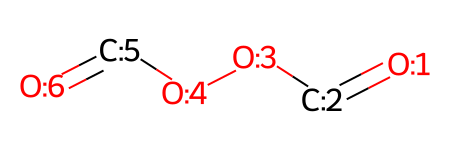

In [39]:
mol_smiles = "[O:1]=[CH:2][O:3][O:4][CH:5]=[O:6]"
# mol_smiles = "[O:1]=[CH:2][c:3]1[cH:4][cH:5][cH:6][c:7](-[c:8]2[cH:9][cH:10][c:11]([Cl:12])[cH:13][cH:14]2)[cH:15]1"
mol = Chem.MolFromSmiles(mol_smiles)

all_maccs_smarts = ['O=CO', 'N=CO', 'c1ccccc1'] # define

mol

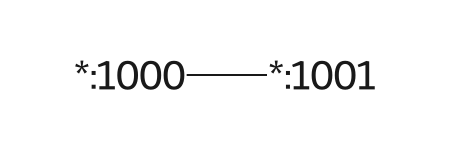

In [40]:
mol, placeholder_to_substruct_dict, all_bonds_for_reconstruction = simplify_substructs(mol, all_maccs_smarts)
mol

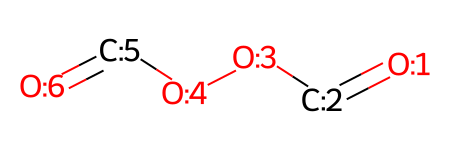

In [41]:
recon_mol = expand_substructs(mol, placeholder_to_substruct_dict, all_bonds_for_reconstruction)
recon_mol

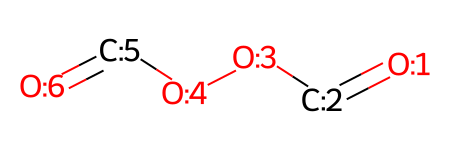

In [2]:
mol_smiles = "[O:1]=[CH:2][O:3][O:4][CH:5]=[O:6]"
mol = Chem.MolFromSmiles(mol_smiles)
mol

In [3]:
mol.GetAtomWithIdx(4).GetSymbol()

'C'

In [4]:
print(mol.GetBondBetweenAtoms(1, None))

ArgumentError: Python argument types in
    Mol.GetBondBetweenAtoms(Mol, int, NoneType)
did not match C++ signature:
    GetBondBetweenAtoms(class RDKit::ROMol {lvalue}, unsigned int, unsigned int)

In [5]:
mol.GetNumAtoms()

6